# Generate samples for the Deforestation Paper with multi-temporal stack

In [1]:
import sys
import os
# import pylab as plt
import numpy as np
# from matplotlib.colors import ListedColormap
from osgeo import gdal
# from osgeo import ogr
from importlib import reload
# import skimage

sys.path.insert(0, '../../src')
import deepgeo.dataset.dataset_generator as dsgen
import deepgeo.dataset.rasterizer as rstzr
import deepgeo.dataset.preprocessor as prep
import deepgeo.dataset.sequential_chips as seq_cg
import deepgeo.common.geofunctions as gf
import deepgeo.common.visualization as vis

reload(rstzr)
reload(prep)
reload(seq_cg)
reload(gf)
reload(vis)

%matplotlib inline

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Input Files
DATA_DIR = "/home/raian/doutorado/Dados/generated"
shape_file = os.path.join(DATA_DIR, 'Prodes_mosaic.shp')
rasters_dir = os.path.join(DATA_DIR, 'images_5bands')

years = [2013, 2014, 2015, 2016, 2017]

raster_files = [os.path.join(rasters_dir, 'mosaic_%d.tif' % i) for i in years]

m_class_names = ['no data', 'not deforestation', 'deforestation', 'clouds']

# Output Files
output_path = DATA_DIR
out_labels_path = os.path.join(DATA_DIR, 'labels_one_def_cl')
out_labels = [os.path.join(out_labels_path, 'labels_cloudless_%d.tif' % i) for i in years]

# output_shp = os.path.join(output_path, "new_samples.shp")
output_ds = os.path.join(output_path, 'dataset_286x286_def_one_class-%s-%s' % (years[0], years[-1]))
ds_file_name = 'dataset'

chip_size = 286

## Load labels

SHAPE:  (11534, 13587, 1)
UNIQUE:  [0 1 2 3]
TYPE:  int32
SHAPE:  (11534, 13587, 1)
UNIQUE:  [0 1 2 3]
TYPE:  int32
SHAPE:  (11534, 13587, 1)
UNIQUE:  [0 1 2 3]
TYPE:  int32
SHAPE:  (11534, 13587, 1)
UNIQUE:  [0 1 2 3]
TYPE:  int32
SHAPE:  (11534, 13587, 1)
UNIQUE:  [0 1 2 3]
TYPE:  int32


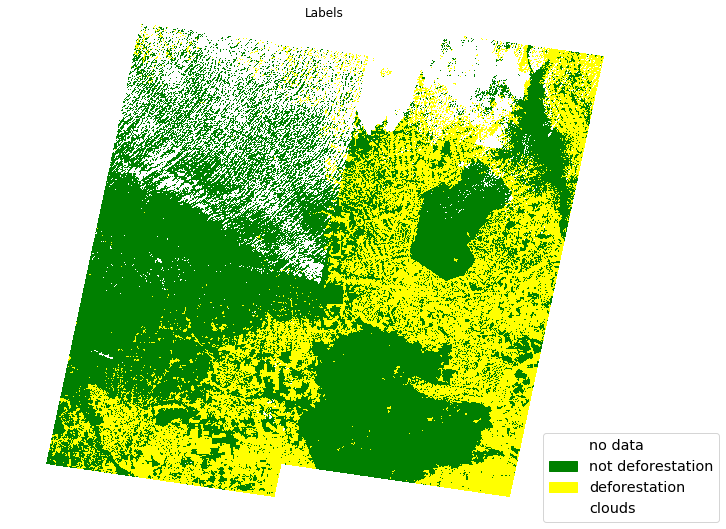

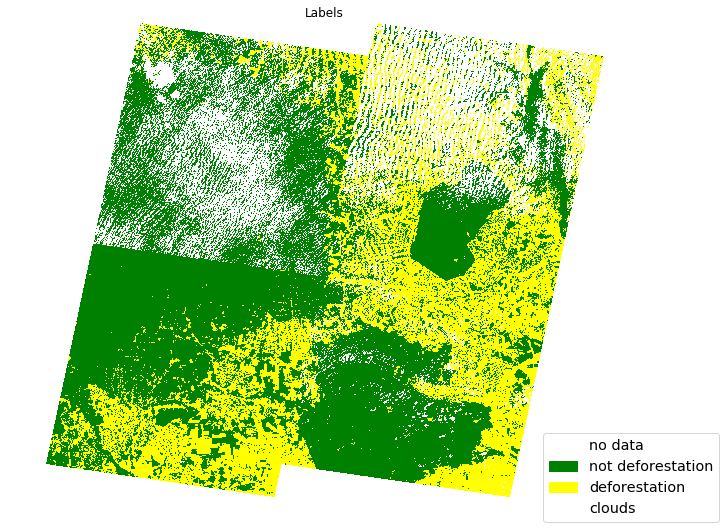

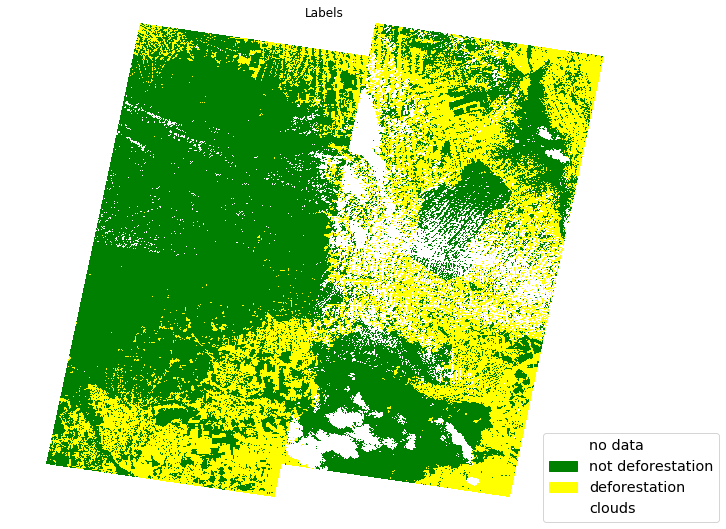

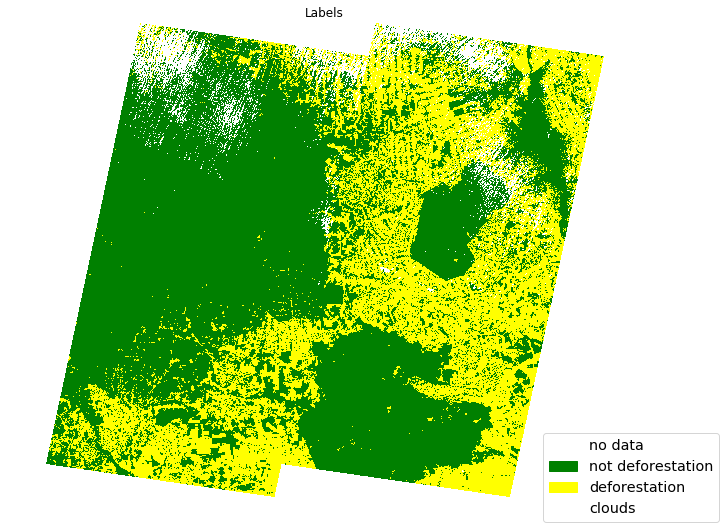

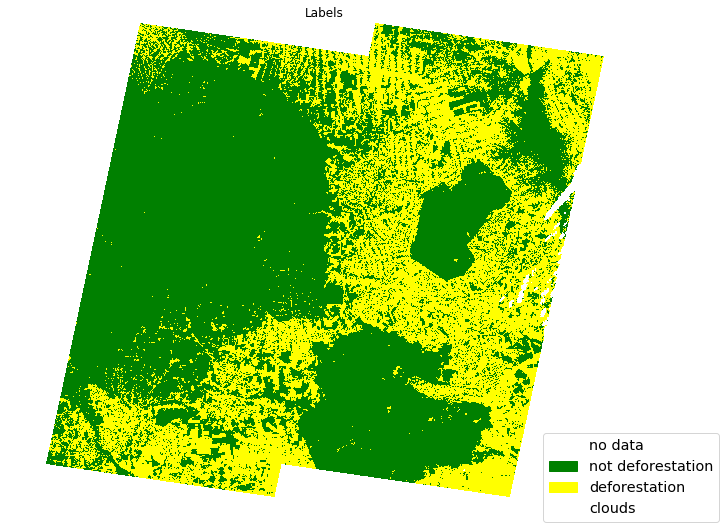

In [3]:
reload(vis)
rasterized_layers = []
for year in range(0, len(out_labels)):    
    ds = gdal.Open(out_labels[year])
    rs = ds.ReadAsArray()
    rasterized_layers.append(np.expand_dims(rs.astype(np.int32), -1))
    print('SHAPE: ', rasterized_layers[year].shape)
    print('UNIQUE: ', np.unique(rasterized_layers[year]))
    print('TYPE: ', rasterized_layers[year].dtype)
    
    vis.plot_labels(rasterized_layers[year], m_class_names, colors=['white', 'green', 'yellow', 'white'])

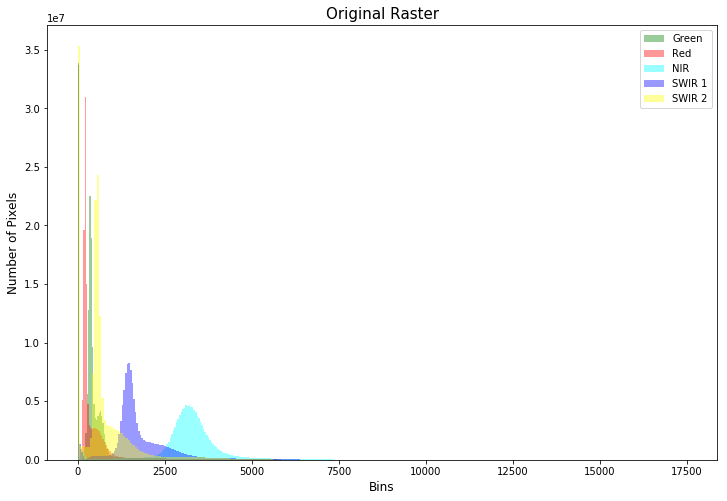

SHAPE:  (11534, 13587, 5)


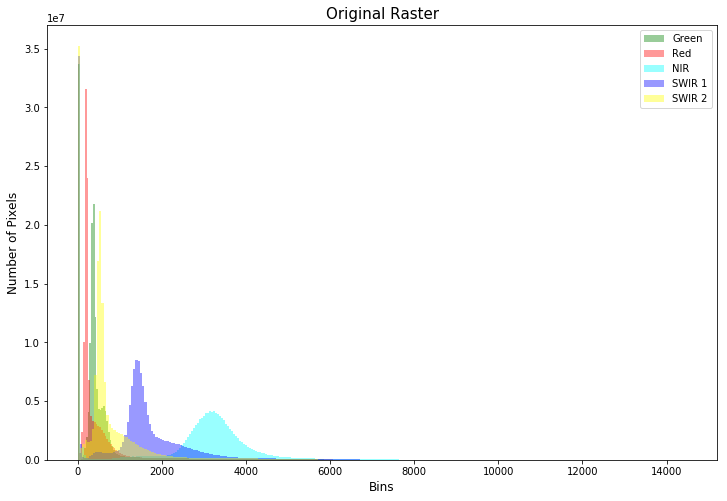

SHAPE:  (11534, 13587, 5)


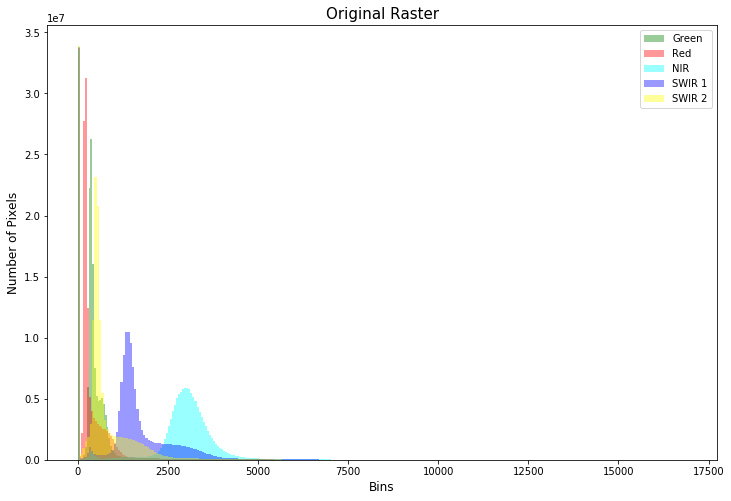

SHAPE:  (11534, 13587, 5)


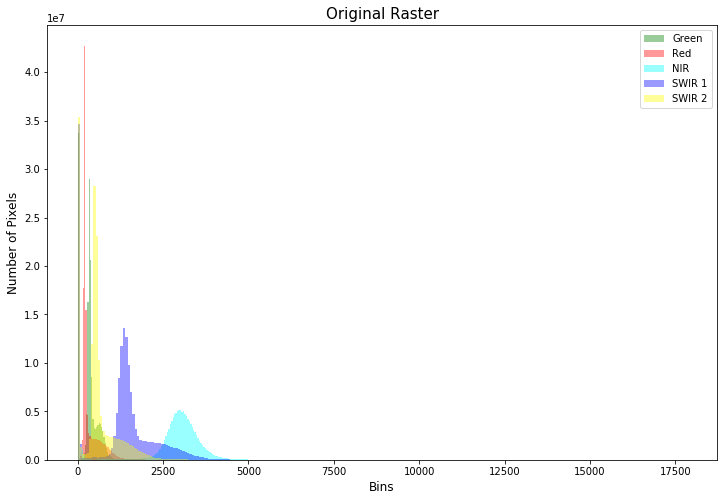

SHAPE:  (11534, 13587, 5)


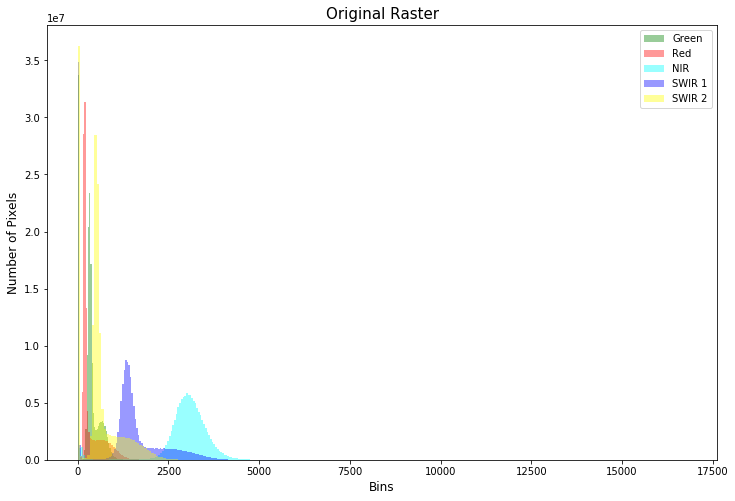

SHAPE:  (11534, 13587, 5)


In [4]:
raster_arrays = []
for file in raster_files:
    preproc = prep.Preprocessor(file, no_data=-9999)
    preproc.remove_bands([0])
    preproc.set_nodata_value(-10)
    original_raster = preproc.get_raster_stacked_raster()

    vis.plot_image_histogram(original_raster, cmap=["green", "red", "cyan", "blue", "yellow"],
                             title="Original Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])
#     vis.plot_rgb_img(original_raster, bands=[3,2,1], contrast=True)
    
    preproc.standardize_image('median_std')
    raster_arrays.append(preproc.get_raster_stacked_raster())
    print('SHAPE: ', preproc.get_raster_stacked_raster().shape)

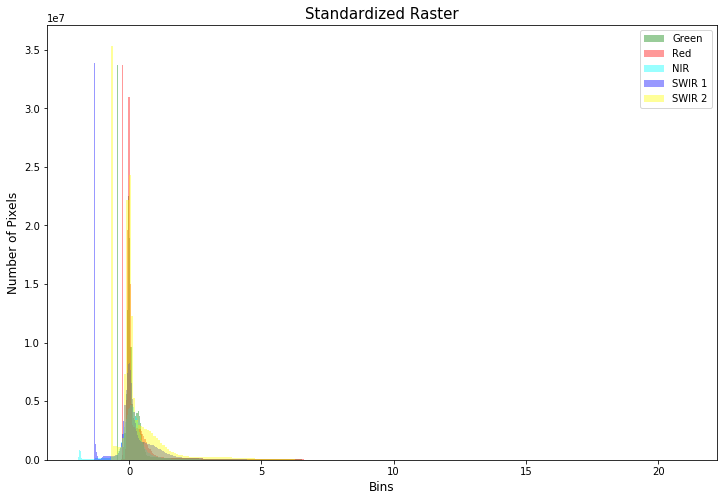

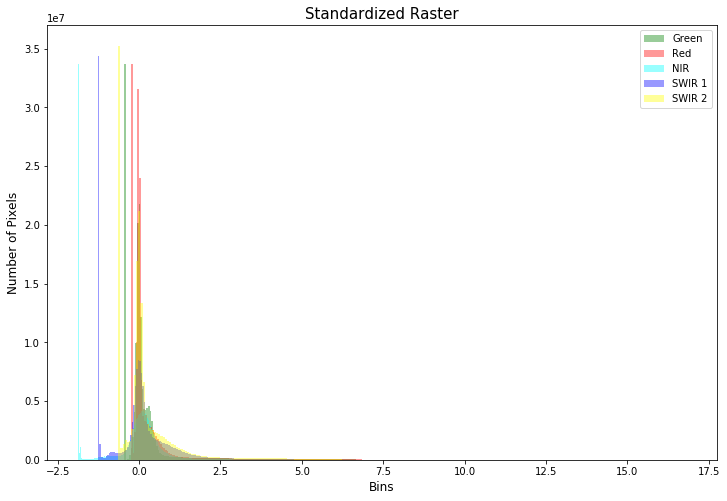

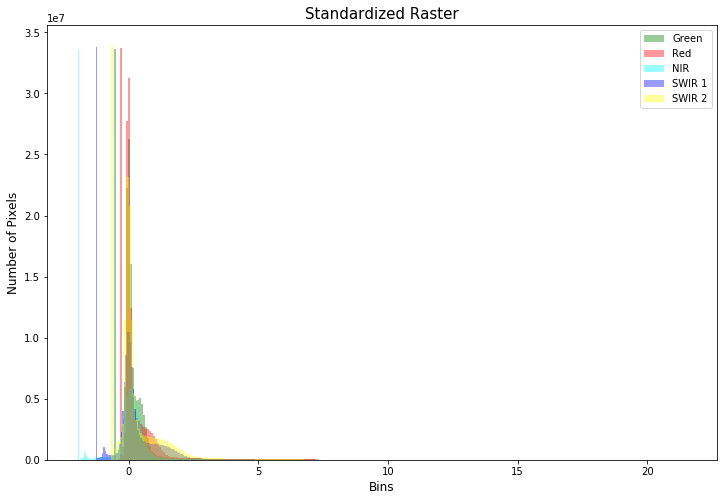

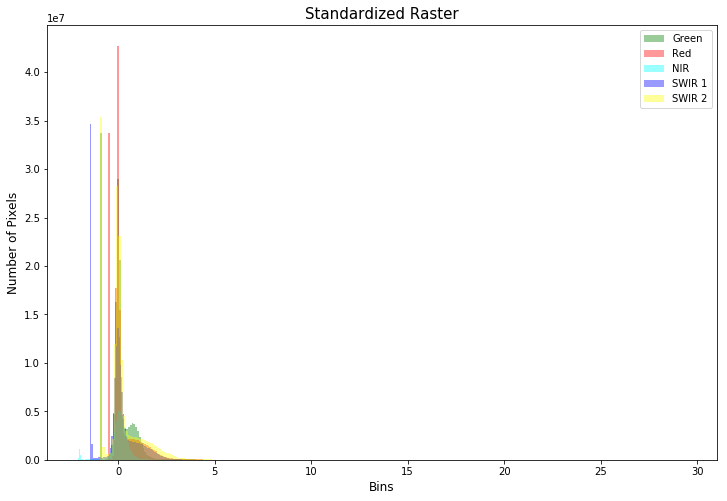

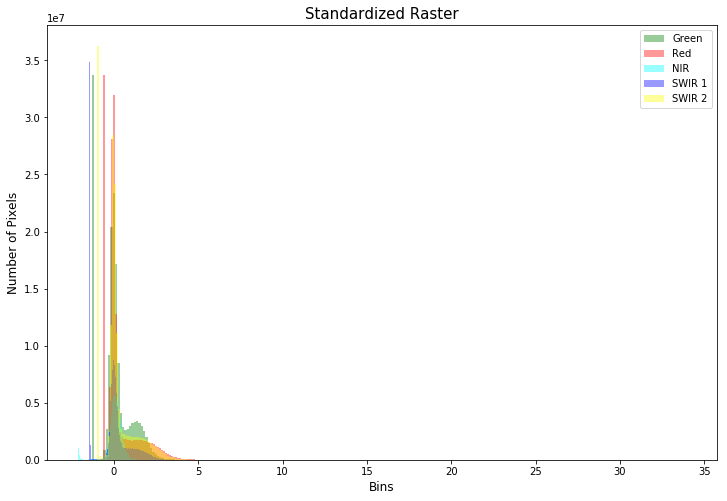

In [5]:
for array in raster_arrays:
    vis.plot_image_histogram(array, cmap=["green", "red", "cyan", "blue", "yellow"],
                             title="Standardized Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])

In [6]:
for i in rasterized_layers:
    print(np.unique(i))

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


In [7]:
generator = dsgen.DatasetGenerator(raster_arrays, rasterized_layers)
params = {'win_size': chip_size}
generator.generate_chips(params)
chip_struct = generator.get_samples()
# vis.plot_chips(chip_struct, raster_arrays[0], bands=[8, 7, 6], contrast=False)
generator.remove_no_data()
generator.shuffle_ds()
generator.split_ds()
generator.save_to_disk(output_ds, ds_file_name)
# chip_struct = generator.get_samples()
# vis.plot_chips(chip_struct, raster_arrays[0], bands=[8, 7, 6], contrast=False)

# =========================================
# TODO: Move this dataset generation to a .py 
# file and keep this notebook only for plotting strategies.
# Put progress bar here
# =========================================

  -> Generating chips...
  -> Removing no data chips...
  -> Shuffling Dataset...
  -> Splitting Dataset...
  -> Saving Datasets to disk...


In [8]:
# chip_struct = {'chips': [],
#                'labels': [],
#                'classes': class_names}
# for i in range(0, len(raster_arrays)):
#     params = {'raster_array': raster_arrays[i],
#               'labels_array': rasterized_layers[i],
#               'win_size': chip_size}

#     chips_seq = seq_cg.SequentialChipGenerator(params).generate_chips()
#     vis.plot_chips(chips_seq, raster_arrays[i], bands=[8, 7, 6], contrast=False)
#     print(chips_seq['chips'].shape)
#     chip_struct['chips'].append(chips_seq['chips'])
#     chip_struct['labels'].append(chips_seq['labels'])

# chip_struct['chips'] = np.concatenate(chip_struct['chips'], axis=0)
# chip_struct['labels'] = np.concatenate(chip_struct['labels'], axis=0)

In [9]:
# print(chip_struct['chips'].shape)
# print(chip_struct['labels'].shape)
# print(chip_struct['classes'])